# Explore the nmat
I need to transpose every file to C. How would I do that?

Good to know:
* According to [Accomontage2](https://github.com/billyblu2000/AccoMontage2), C is Tonic 0
* Tracks only have tonics 2, 8, and 11!

In [12]:
import pickle as pkl
import muspy as mp
import numpy as np

with open('data/dataset.pkl', 'rb') as f:
    data = pkl.load(f)

# pick the 10 random samples from "data"
# NOTE: Here I am picking the 10 first samples!!!
top_ten_samples = dict(list(data.items())[:10])

first_key = list(top_ten_samples.keys())[2]



number_of_notes = 0

for note in data[first_key]["nmat"]:
    number_of_notes += 1


number_of_root_notes = 0
for root_notes in data[first_key]["root"]:
    number_of_root_notes += len(root_notes)

print(number_of_root_notes)
print(number_of_notes)

def transpose_nmat(nmat, tonic):
    return nmat[:,2] - tonic

for track_name in list(data.keys()):
    #print(track_name)
    old_nmat = np.array(data[track_name]["nmat"]).copy()
    nmat = np.array(data[track_name]["nmat"])
    tonic = data[track_name]["tonic"]
    nmat[:,2] -= tonic
    # assert that none of the notes are negative
    assert np.all(nmat >= 0)
    # assert that old_nmat and nmat are not the same
    assert not np.all(old_nmat == nmat)


32
22


# Convert nmat to midi

I want to see if I can get a baseline model working. I'll use the same data as in the previous notebook, but I'll use a simpler model.

First I need to understand the ABC-notation-thingie. In the cell below I convert the `nmat` matrix to midi.

In [6]:
import muspy as mp
import numpy as np
import pathlib
import os
import pickle as pkl


def transpose_nmat(track_data):
    """
    Transpose the nmat to 0-tonic, by subtracting the tonic from the third (pitch) column
    TODO I do believe this method mutates the track_data, inplace, so the return statment is not needed
    """
    untransposed_nmat = np.array(track_data["nmat"]).copy()
    nmat = np.array(track_data["nmat"])
    tonic = track_data["tonic"]
    # here is the transposition
    nmat[:,2] -= tonic
    # assert that none of the notes are negative
    assert np.all(nmat >= 0)
    # assert that old_nmat and nmat are not the same
    # (since the dataset only has tonics 2, 8, 11, this should always be true)
    assert not np.all(untransposed_nmat == nmat)
    track_data["nmat"] = nmat
    return track_data


def nmat_to_midi(data, save=True):

    scale = 8
    pieces = list(data.keys())

    for track_name in pieces:
        music = mp.Music() # Create new Music object for each piece
        track = mp.Track() # Create new Track object for each piece
        track_data = data[track_name]

        # this should transpose the nmat to the correct key
        track_data = transpose_nmat(track_data)

        # append midi-meta message of which key the piece is in
        # major tonics are [0,11], minor tonics are [12,23]
        # TODO this is not working!
        # key = 0 if track_data["mode"] == 'M' else 12
        # music.meta.append(mp.KeySignature(key=key))

        for note in track_data['nmat']:
            note = mp.Note(time=scale*note[0], pitch=note[2], duration=int(scale*(max(note[1]-note[0], 0.5))))
            track.notes.append(note)

        music.tracks.append(track) # Append the track to the current Music object
        music.write_midi(f'midi/{track_name}')


# the script
with open('data/dataset.pkl', 'rb') as f:
    data = pkl.load(f)

# pick the 10 random samples from "data"
# NOTE: Here I am picking the 1000 first samples!!!
samples = dict(list(data.items()))

cwd = pathlib.Path.cwd()
midi_dir = cwd / "midi"
abc_dir = cwd / "abc"

# create abc_dir if it doesn't exist
os.makedirs(abc_dir, exist_ok=True)
os.makedirs(midi_dir, exist_ok=True)

# convert the samples to midi
nmat_to_midi(samples)

# Convert midi to ABC-notation

When I have the midi-files, I can convert them to ABC-notation. I'll use the `midi2abc`-package for this. I installed it by using `brew install midi2abc`.

> **NOTE:** The cell below is a practically a bash script. 😁

In [5]:
import os
import subprocess
import pathlib

# specify your directories here
cwd = pathlib.Path.cwd()
midi_dir = cwd / "midi"
abc_dir = cwd / "abc"

# create abc_dir if it doesn't exist
os.makedirs(abc_dir, exist_ok=True)

# convert all midi files to abc, and save them to the abc_dir
for file in os.listdir(midi_dir):
    if file.endswith(".mid"):
        base = os.path.splitext(file)[0]
        input_file = os.path.join(midi_dir, file)
        output_file = os.path.join(abc_dir, base + ".abc")

        #print(f"Processing {input_file}")
        subprocess.run(["midi2abc", "-o", output_file, input_file])


# Super regex

From a friend of a friend I got a regex that can extract the notes from the ABC-notation. I'll use that to extract the notes from the ABC-notation.

In [8]:
import re

def regex_split(abc):
    # Regular expression pattern
    expressions = ["~","|","-",
      "\|[\[]?1|:\|[\[]2", #first and second endings
      '\"\(?[A-G|a-g][b|\#]?[m|d|a|7]?(6|7|b9)?\)?(/[A-G|a-g][b|\#]?[m|7]?)?\"', # chords between ""
      # "\|Y:\s*(?<=[ABCDEFG])\s(?=[ABCDEFG])?"
      "/?(2|3|4|5|6|7|8|9|12|16)",#duration
      "M:\d/\d", # meter
      "L:1/(4|8|16)", #base duration
      "K:[ABCDEFG](maj|min|m|dor)?", #key
      ":?\|:?", # vertical bar or repetition
      "\([\d]|", # triplets like this (3 
      "[\^\_\=]?[ABCDEFG][,]?", #low octave notes
      "[\^\_\=]?[abcdefg][']?", #high octave notes
      "z", # pause
      "(>|<)", # broken rhythm
      "\[|\]", # square brackets
    ]
    pattern = "|".join(expressions)

    REGEX = re.compile(pattern)

    # remove empty chords
    abc = re.sub('" "','',abc)
    # remove spaces
    abc = re.sub(' ','',abc)

    # replace + with # for sharps
    abc = re.sub(r"c\+", "c#", abc)
    abc = re.sub(r"d\+", "d#", abc)
    abc = re.sub(r"f\+", "f#", abc)
    abc = re.sub(r"g\+", "g#", abc)

    # replace :: with :||:
    abc = re.sub(r":[\|]?:", ":||:", abc)
    # replace \
    abc = re.sub(r"\\", "", abc)


    # remove all lines that start with %
    abc = re.sub(r'(?m)^\%.*\n?','',abc)
    # remove everything between !
    abc = re.sub(r'![^!]+!','',abc)

    # remove all lines that start with X:,T:,S:
    abc = re.sub(r'(?m)^[XTSPYNQR]:?.*\n?','',abc)
    # print(abc)

    abc = re.sub(REGEX, lambda y: y.group() + ' ', abc)
    # print(abc)

    return abc

Test the regex on one file and see what comes out?

In [45]:
abc_file = open('abc/Niko_Kotoulas__RhythmChordProg_2_A-Bm-D-G (V-vi-I-IV).abc', 'r')

total_tokens = regex_split(abc_file.read())

# print the total tokens
print(total_tokens)

# split total_tokens by space and remove empty strings
total_tokens = total_tokens.split(' ')
total_tokens = list(filter(None, total_tokens))

# print total tokens
print(total_tokens)

# print total number of unique tokens
print(set(total_tokens))

 M:4/4  
 L:1/8  
 K:D  % 2  s h a  r p s 
 V : 1 
 [  E,  B,  , A,  , E,  , A,  , , -  ]  3  /2  A,  , , /2  [  E,  B,  , A,  , E,  , A,  , , ]  3  /2  z  /2  [  E,  B,  , E,  , A,  , , ]  /2  z  [  D,  A,  , F,  , B,  , , -  ]  3  /2  B,  , , /2  [  D,  -  A,  , -  F,  , -  B,  , , -  ]  /2  |  
 [  D,  A,  , F,  , B,  , , ]  z  /2  [  D,  A,  , F,  , B,  , , ]  /2  z  [  E,  D,  A,  , D,  , D,  , , ]  3  /2  z  /2  [  D,  A,  , -  D,  , -  D,  , , -  ]  /2  [  A,  , D,  , D,  , , ]  z  /2  [  D,  A,  , D,  , D,  , , ]  /2  z  /2  |  
 z  /2  [  G,  D,  A,  , D,  , G,  , , ]  2  [  D,  A,  , D,  , G,  , , -  ]  /2  G,  , , z  /2  [  D,  A,  , D,  , G,  , , ]  /2  
 
['M:4/4', '\n', 'L:1/8', '\n', 'K:D', '%', '2', 's', 'h', 'a', 'r', 'p', 's', '\n', 'V', ':', '1', '\n', '[', 'E,', 'B,', ',', 'A,', ',', 'E,', ',', 'A,', ',', ',', '-', ']', '3', '/2', 'A,', ',', ',', '/2', '[', 'E,', 'B,', ',', 'A,', ',', 'E,', ',', 'A,', ',', ',', ']', '3', '/2', 'z', '/2', '[', 'E,', 'B,', ',', 'E,', 

# Count tokens and plot distribution
Now I use a defaultdict to count the tokens with the regex in the cell above. Then I plot the distribution.

Total amaount of unique tokens:  103
Printing the total_tokes dictionary:  defaultdict(<class 'int'>, {'M:4/4': 5762, '\n': 40615, 'L:1/8': 5762, 'K:F': 334, '%': 5762, '1': 6530, 'f': 614, 'l': 484, 'a': 5819, 't': 484, 's': 11040, 'V': 5762, ':': 5762, '[': 98586, 'C': 15020, 'E,': 58501, '-': 253625, 'A,': 70908, ',': 449973, ']': 98586, '2': 6378, '/2': 94302, 'c': 2555, 'z': 16051, 'A': 3507, 'C,': 75252, 'F,': 44569, '|': 12488, 'G': 6474, 'G,': 70874, '3': 15617, 'D': 7253, 'D,': 46427, '4': 7612, 'K:C': 4790, '0': 4790, 'h': 5278, 'r': 5278, 'p': 5278, 'B,': 38050, '^G,': 546, '^C,': 170, 'K:G': 434, 'K:B': 118, 'b': 175, 'F': 2852, 'E': 5375, '=F,': 285, '^F': 139, 'B': 2116, '(3': 314, 'd': 829, 'e': 340, '^F,': 518, '=F': 43, '_D,': 27, '=B,': 41, '_G,': 33, '=D,': 28, '=G,': 114, '=E': 10, '_E': 19, '>': 104, '_A,': 14, '_E,': 67, '=E,': 57, '=A,': 34, 'g': 120, "c'": 28, '^D,': 123, 'K:A': 8, '^d': 15, '6': 2, 'K:E': 26, '^G': 82, '^A,': 51, '^C': 116, '_B,': 17, '<': 15, 

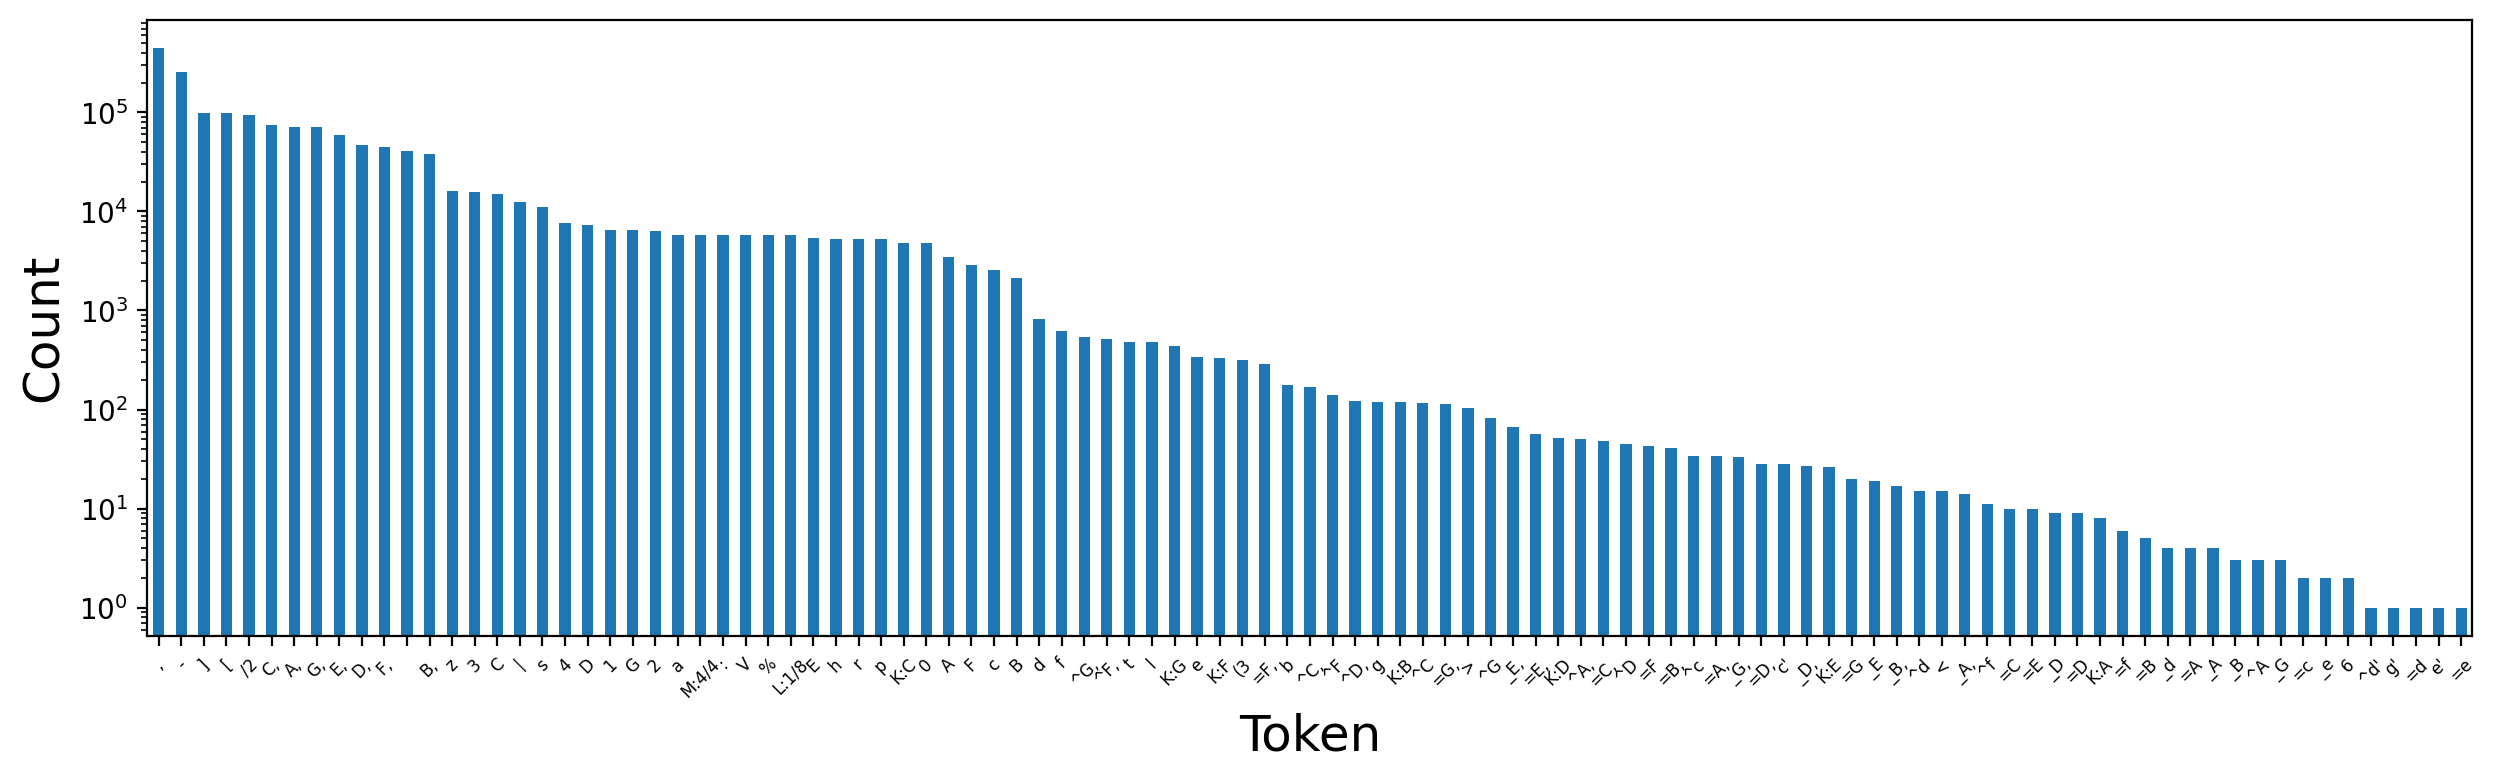

In [9]:
from collections import defaultdict
import os
import pandas as pd
import matplotlib.pyplot as plt

# for all files in the 'abc' folder

total_tokens = defaultdict(int)

"""
I'd like a dataframe where each rows is a file, and each column a token count.
First I would have to create a dictionary with the token counts for each file, 
and then save the set of tokens as the columns of the dataframe.
That would allow different types of aggregation, like summing the counts of all, etc. 
"""

for path_to_file in os.listdir('abc'):
    # open the file
    with open(f'abc/{path_to_file}', 'r') as file:
        contents = file.read()
        tokens = regex_split(contents)
        # split total_tokens by space and remove empty strings
        tokens = tokens.split(' ')
        tokens = list(filter(None, tokens))
        # count the number of each token
        for token in tokens:
            total_tokens[token] += 1

# print the length of the total tokens
print("Total amaount of unique tokens: ", len(total_tokens))

# print the total tokens
print("Printing the total_tokes dictionary: ", total_tokens)

# convert the dictionary to a pandas dataframe
df = pd.DataFrame.from_dict(total_tokens, orient='index', columns=['count'])

# sort the dataframe by count
df = df.sort_values(by=['count'], ascending=False)

# print the dataframe
df.plot(kind='bar', figsize=(15,4))

# set the x-axis font size to 12
plt.xticks(fontsize=6)

# set the x axis label to 'token'
plt.xlabel('Token', fontsize=18)

# set the y axis label to 'count'
plt.ylabel('Count', fontsize=18)

# set y-axis to log scale
plt.yscale('log')

# rotate the x axis labels 45 degrees
plt.xticks(rotation=45)

# remove the legend
plt.legend().remove()


# Try a different counting strategy

I want to make a table where each row is a file, and the tokens are columns. Then I'll aggregate that table for various visualisations.

In [15]:
from collections import defaultdict
import os
import pandas as pd
import matplotlib.pyplot as plt

items = []

for path_to_file in os.listdir('abc'):
    total_tokens = defaultdict(int)
    # open the file
    with open(f'abc/{path_to_file}', 'r') as file:
        contents = file.read()
        tokens = regex_split(contents)
        # split total_tokens by space and remove empty strings
        tokens = tokens.split(' ')
        tokens = list(filter(None, tokens))
        # count the number of each token
        for token in tokens:
            total_tokens[token] += 1
    # finally, append a tuple with the filename and the total_tokens
    items.append((path_to_file, total_tokens))

# find the total number of unique tokens
unique_tokens = set()
for item in items:
    unique_tokens.update(item[1].keys())

# add "filename" as a column
unique_tokens.add('filename')

# make a dataframe with the unique tokens as columns
df = pd.DataFrame(columns=list(unique_tokens))

# add the counts of each token to the dataframe
dataframes = []  # create a list to store all the dataframes
for item in items:
    # create dataframe with index as filename
    temp_df = pd.DataFrame(item[1], index=[item[0]])
    dataframes.append(temp_df)

# concatenate all dataframes
df = pd.concat(dataframes, ignore_index=False)

# fill all NaN values with 0
df = df.fillna(0)

From here, I analyze the Dataframe created above.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


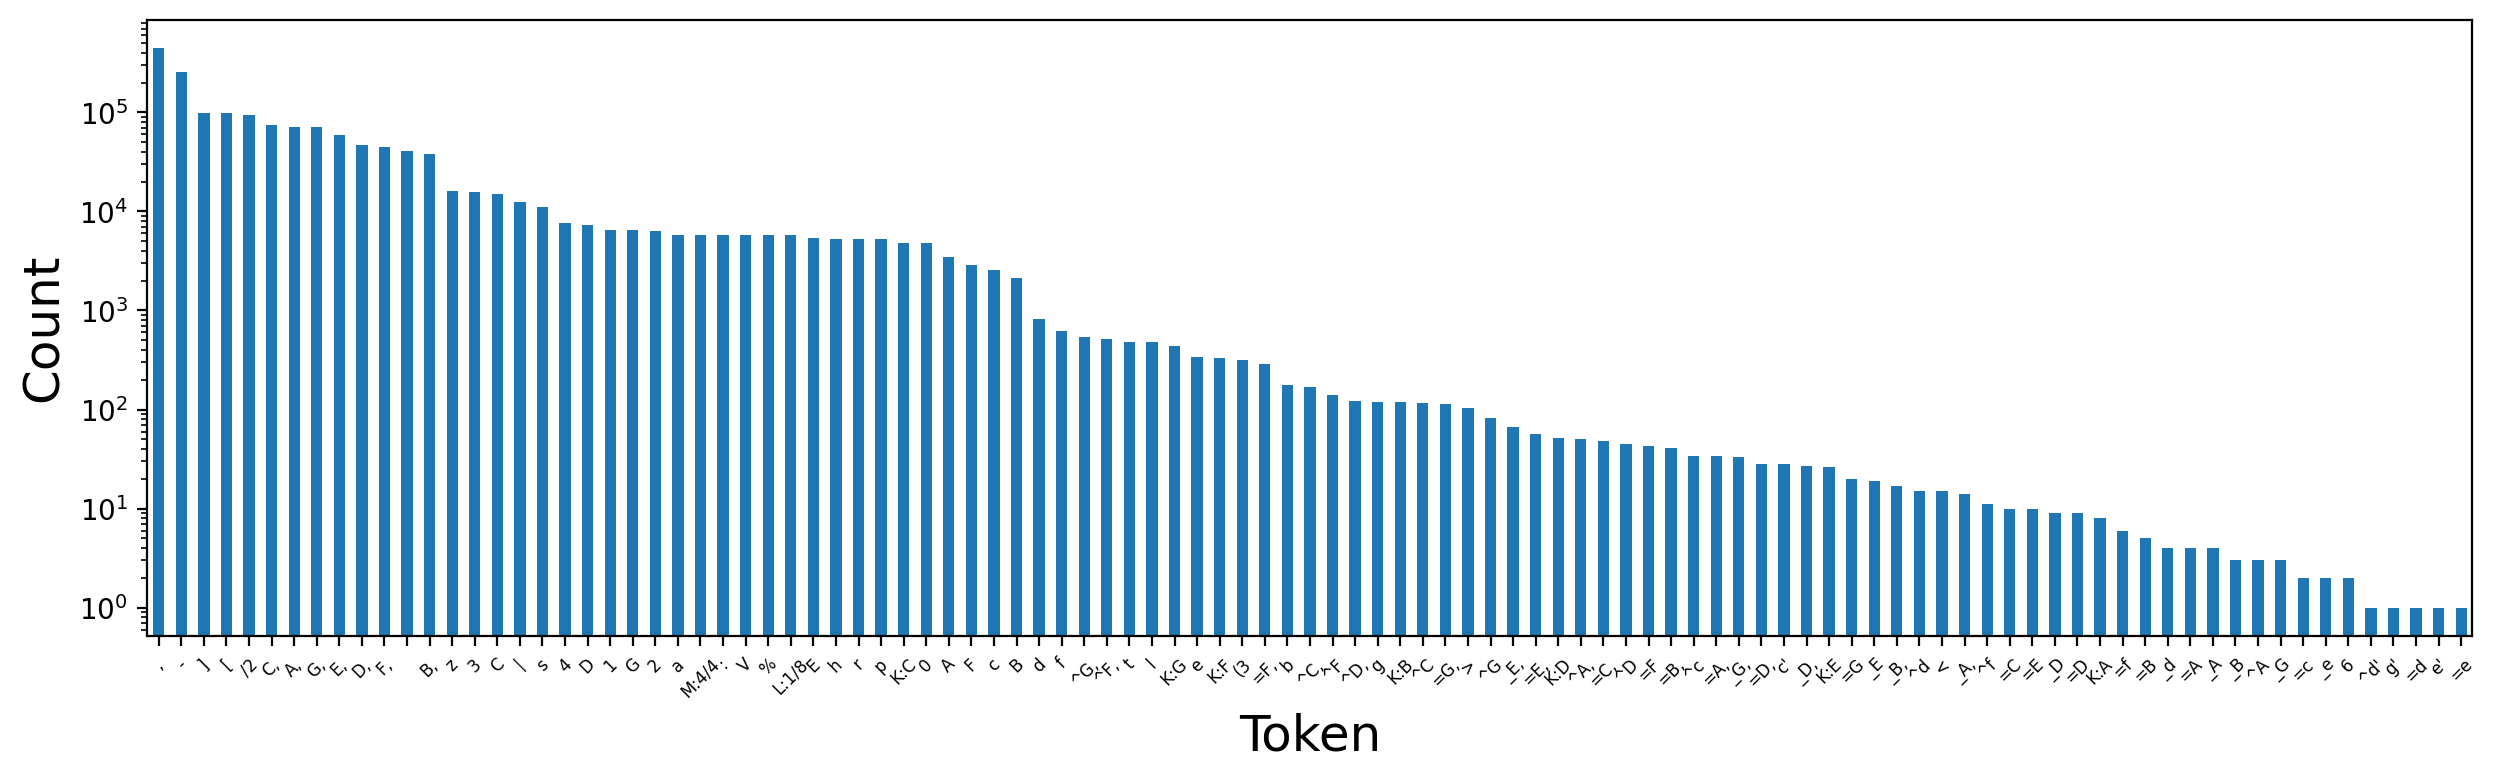

In [16]:
# sum over axis=0 and sort by frequency
df.sum(axis=0).sort_values(ascending=False).plot(kind='bar', figsize=(15,4))

# set the x-axis font size to 12
plt.xticks(fontsize=6)

# set the x axis label to 'token'
plt.xlabel('Token', fontsize=18)

# set the y axis label to 'count'
plt.ylabel('Count', fontsize=18)

# set y-axis to log scale
plt.yscale('log')

# rotate the x axis labels 45 degrees
plt.xticks(rotation=45)

# remove the legend
plt.legend().remove();

To get a sense of how diverse the samples are, I'll plot the distribution of uniqe tokens. I deem it not to be a good plot?

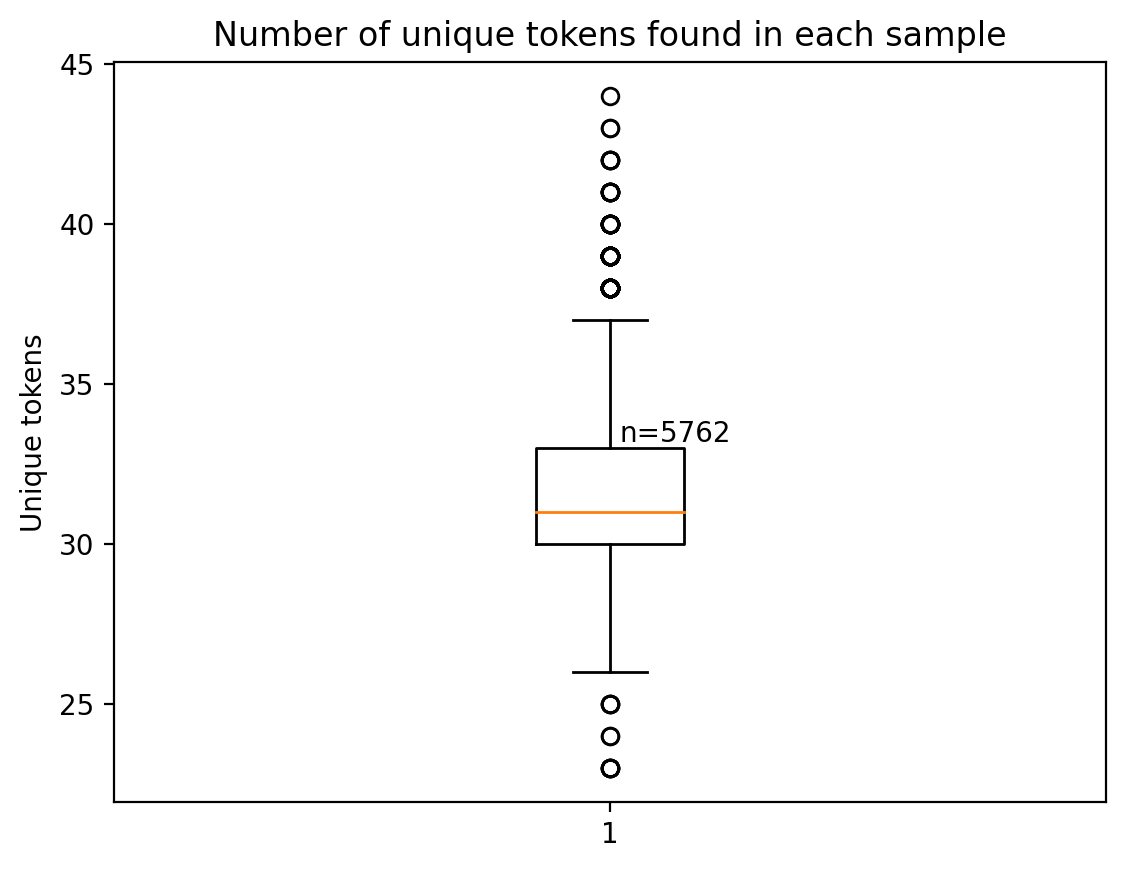

In [38]:
# count all non-zero values in each row
non_zero_counts = df.astype(bool).sum(axis=1)
plt.boxplot(non_zero_counts)
plt.title('Number of unique tokens found in each sample')
plt.ylabel('Unique tokens')
# add n=datapoints on the boxplot
n = len(non_zero_counts)
# hard coded x and y axis love me for it
plt.text(1.01, 33.2, f'n={n}')
plt.show()

Another idea is to label each token as a note, a rest, or a chord. Then I can plot the distribution of these labels in a unified histogram plot. Overkill, but nice.

In [50]:
df.columns

Index(['M:4/4', '\n', 'L:1/8', 'K:G', '%', '1', 's', 'h', 'a', 'r',
       ...
       '^a', '=a', '^f'', '=b', '_e'', '_d', '_b', '_A', '^c'', '''],
      dtype='object', length=126)

# Try to do a baseline model


index    286
count    286
dtype: int64


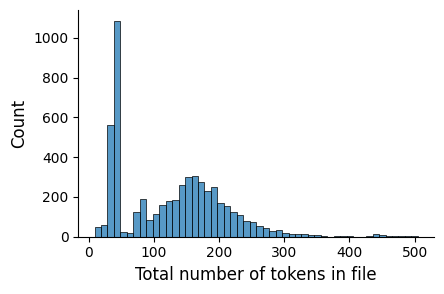

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# read each new line in data/dataset.txt and split it by space
with open('data/dataset.txt', 'r') as file:
    lines = file.readlines()
    lines = [line.strip().split(' ') for line in lines]
    # save a tuple of the index and the count of total tokens for each line
    lines = [(i, len(line)) for i,line in enumerate(lines)]
    # save it as a dataframe
    df = pd.DataFrame(lines, columns=['index', 'count'])

# print the amount of files with more than 300 tokens
print(df[df['count'] > 256].count())

#df.hist(column='count', bins=50, figsize=(3,3));
sns.displot(df['count'], bins=50, kde=False, height=3, aspect=1.5);

# renamy y-axis to 'Total number of tokens in file'
plt.ylabel('Count', fontsize=12);
plt.xlabel('Total number of tokens in file', fontsize=12);

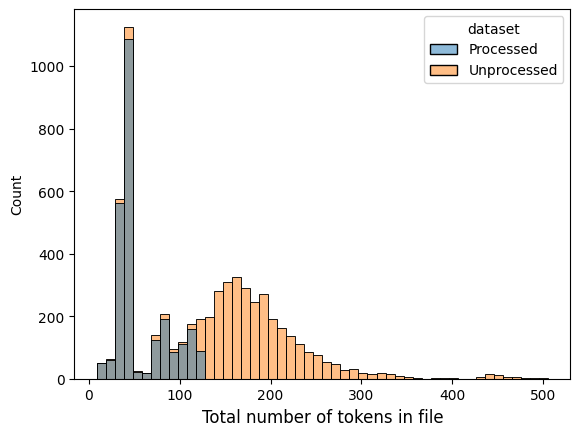

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# read each new line in data/dataset.txt and split it by space

with open('data/dataset_processed.txt', 'r') as file:
    lines_processed = file.readlines()
    lines_processed = [line.strip().split(' ') for line in lines_processed]
    lines_processed = [(i, len(line), len(set(line)), 'Processed') for i, line in enumerate(lines_processed)]

with open('data/dataset_full.txt', 'r') as file:
    lines_full = file.readlines()
    lines_full = [line.strip().split(' ') for line in lines_full]
    lines_full = [(i, len(line), len(set(line)), 'Unprocessed') for i, line in enumerate(lines_full)]

# combine the two lists
lines_combined = lines_processed + lines_full

df = pd.DataFrame(lines_combined, columns=['index', 'count', 'unique', 'dataset'])

# do a seaborn histplot with hue as dataset
sns.histplot(data=df, x='count', hue='dataset', multiple="" ,bins=50, kde=False);

# rename x-axis to 'Total number of tokens in file'
plt.xlabel('Total number of tokens in file', fontsize=12);